In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [22]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

In [23]:
X_train.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1009.489990,1009.489990,1009.489990,1009.489990,1009.489990,-2.605886,15376.620117,15376.620117,15073.950195,15127.000000,15127.000000,-2.745965,15795.150391,15795.150391,15424.709961,15513.570313,15513.570313,-1.984805
1,1015.780029,1015.780029,1015.780029,1015.780029,1015.780029,0.623091,15071.919922,15244.650391,14883.320313,15074.799805,15074.799805,-0.345080,15491.799805,15580.320313,15392.740234,15550.639648,15550.639648,0.238948
2,1022.469971,1022.469971,1022.469971,1022.469971,1022.469971,0.658601,14679.990234,14786.040039,14494.379883,14680.500000,14680.500000,-2.615622,15516.150391,15516.150391,15101.639648,15330.309570,15330.309570,-1.416855
3,1026.880005,1026.880005,1026.880005,1026.880005,1026.880005,0.431312,15185.679688,15284.650391,14956.879883,14973.400391,14973.400391,1.995166,15366.809570,15688.169922,15366.809570,15512.320313,15512.320313,1.187261
4,1021.460022,1021.460022,1021.460022,1021.460022,1021.460022,-0.527811,15081.759766,15134.530273,14794.809570,14873.429688,14873.429688,-0.667655,15526.990234,15545.059570,15340.219727,15340.219727,15340.219727,-1.109445
5,1003.859985,1003.859985,1003.859985,1003.859985,1003.859985,-1.723027,14751.940430,14751.940430,14356.059570,14458.519531,14458.519531,-2.789606,15324.349609,15324.349609,14832.969727,14872.480469,14872.480469,-3.049104
6,1025.310059,1025.310059,1025.310059,1025.310059,1025.310059,2.136760,14352.419922,14422.519531,14107.740234,14422.519531,14422.519531,-0.248988,14901.110352,15027.129883,14707.879883,14811.080078,14811.080078,-0.412846
7,1038.229980,1038.229980,1038.229980,1038.229980,1038.229980,1.260099,14822.429688,15105.450195,14822.429688,15044.530273,15044.530273,4.312774,14842.809570,15314.969727,14842.809570,15198.730469,15198.730469,2.617300
8,1045.369995,1045.369995,1045.369995,1045.369995,1045.369995,0.687710,15038.250000,15161.030273,14864.830078,15102.360352,15102.360352,0.384393,15197.929688,15224.809570,15035.240234,15097.959961,15097.959961,-0.663019
9,1066.640015,1066.640015,1066.640015,1066.640015,1066.640015,2.034688,15125.830078,15209.339844,14885.650391,14925.929688,14925.929688,-1.168232,15100.080078,15229.459961,15066.599609,15148.190430,15148.190430,0.332697


In [24]:
y_train.head(5)

,0
0,-1.050990
1,-3.641421
2,1.570565
3,0.457411
4,-1.456126


In [46]:
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor())) 
###reshape data for RandomForestRegressor
###boosted ntrees (xg_boost)
###suppoort vector machines

In [39]:
results = []
names = []

for name, model in models:
    tscv = TimeSeriesSplit(n_splits=10)
    model.fit(X_train, y_train)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    ###scoring : neg_mean_squared_error, neg_mean_absolute_error, r2
    names.append(name)
    results.append(cv_results)
    
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: -0.797767 (0.628795)
KNN: -1.669319 (1.253311)


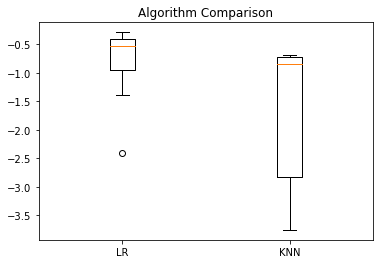

In [40]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [41]:
models

[('LR', LinearRegression()), ('KNN', KNeighborsRegressor())]

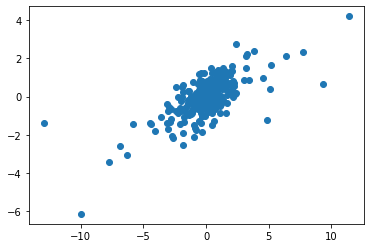

In [42]:
y_pred_LR = models[0][1].predict(X_test)
plt.scatter(y_test, y_pred_LR)

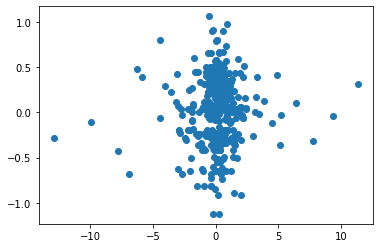

In [43]:
y_predK = models[1][1].predict(X_test)
plt.scatter(y_test, y_predK)
####Hyper parameters

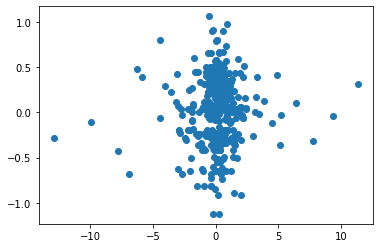

In [44]:
y_predRF = models[1][1].predict(X_test)
plt.scatter(y_test, y_predRF)

In [47]:
###find best base model
###improve other mldels with hyperparameter
#### find best model

In [48]:
###two results based on shifted time